PW: 50 - 800 μs
Amplitude: 0 - 9 mA


In [54]:
#To load potential distribution, run here to save time during simulation reruns
import numpy as np

n_files = 1     #Number of comsol potential distribution files
#distances = {'key1': 'value1', 'key2': 'value2', 'key3': 'value3'}

matrix_data = [[] for _ in range(n_files)]
#for i in range(n_files):
for i in range(0,1):    
    print(i)
    filename = 'potentials_'+str(i)+'.txt'
    with open(filename, 'r') as file:
        # Read lines from the file
         lines = file.readlines()
    for line in lines:
        elements = line.strip().split()
        matrix_data[i].append([float(elem) for elem in elements])

potentials = np.array(matrix_data)

0


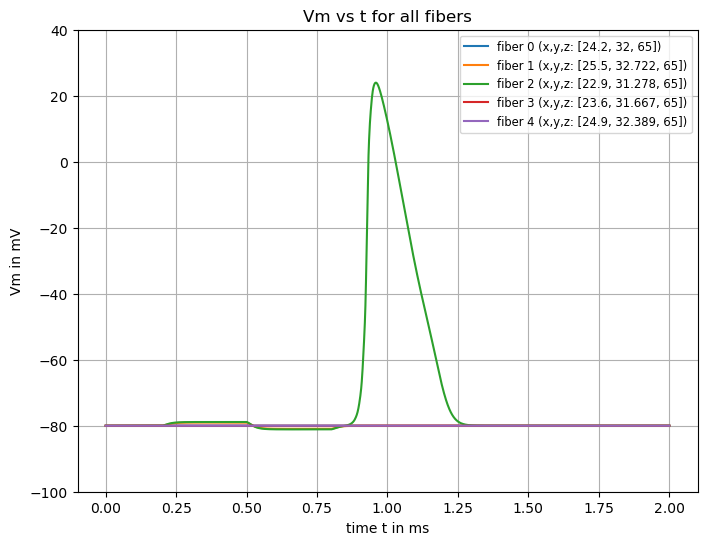

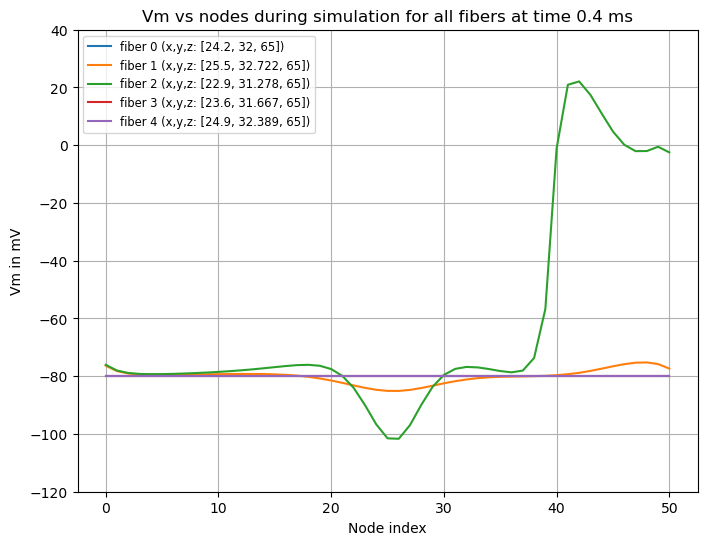

NEURON: point process not located in a section
 near line 0
 ^


TypeError: No value

In [59]:
#Simulate n fibers using Sweeney model
#Note: Potentials generated for 1mA current, amplitude scaled using 'amplitude' variable, 
#Adjust electrode_xyz and fiber_xyz based on COMSOL

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
n_nodes = 51  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
#electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 2   #simulation duration in ms
dt = 0.001  #simulation time step in ms
h.dt = 0.001   #simulation time step in ms
amplitudes = [1,2,3,4,5,6,7,8,9]   #stimulation amplitudes in mA
pulsewidths = np.array([50,100,200,300,400,600,800])*0.001   #stimulation pulsewidths in ms
#pulserates = [1,2,5,10,20,30,40]   #stimulation pulse rates in Hz

diameter_PTN = 12  #PTN fiber diameter in μm
diameter_SAFN = 12  #SAFN fiber diameter in μm 
n_fibers_PTN = 5   #number of fibers for PTN
n_fibers_SAFN = 5   #number of fibers for SAFN


# OLD PTN fibers central node [x,y,z] coordinates as per COMSOL, in mm 
fibers_xyz_PTN = [[24.2,32,65],
             [25.5,32.722,65],
             [22.9,31.278,65],
             [23.6,31.667,65],
             [24.9,32.389,65]]

'''
# PTN fibers central node [x,y,z] coordinates as per COMSOL, in mm  
fibers_xyz_PTN = [[24.2,32,50],              # centre point reference     
             [23.1,31.2,50],        # Point 1 closest to electrode
             [23.3,33,50],          # Point 2 clockwise from point 1
             [25.3,32.8,50],      # Point 3 clockwise from point 1 
             [25.1,31,50]]        # Point 4 clockwise from point 1
'''

#SAFN fibers central node [x,y,z] coordinates as per COMSOL, in mm 
fibers_xyz_SAFN = [[16.8,22.2,50],
             [11.8,32.3,50],
             [8.8,42.2,50],
             [7.4,52.5,50],
             [7.5,62.2,50]]  

electrode_xyz = [18.98,29.1,65]   #small electrode point current source [x,y,z] coordinates as per COMSOL, in mm
electrode2_xyz = [18.98,29.1,35]   #electrode 2 point current source [x,y,z] coordinates as per COMSOL, in mm

#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,n_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #MRG mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))
                
#Utility functions==============================================================================================================                

#Function to get 1D potentials along z axis for a particular (x,y)
def get_potentials_z(potentials,x,y):
    '''
    potentials: COMSOL 3D potential distribution
    x: target x, in mm
    y: target y, in mm
    '''
    # Define tolerance
    tolerance = 0.05
    # Filter the data based on the target (x, y) value and tolerance
    filtered_data = potentials[(np.abs(potentials[:, 0] - x) <= tolerance) & (np.abs(potentials[:, 1] - y) <= tolerance)]
    # Extract (z, potentials) from the filtered data
    potentials_z = np.column_stack((filtered_data[:, 2], filtered_data[:, 3]))
    
    return potentials_z    
                
#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(n_fibers,diameter,fiber_xyz,electrode_xyz,potentials,amplitude,pulsewidth,Vm_threshold,tstop):
    '''
    n_fibers: number of fibers
    diameter: fiber diameter, in um
    fiber_xyz: fiber central node [[x1,y1,z1],[x2,y2,z2],..] coordinates as per COMSOL in mm
    electrode_xyz: electrode reference point current source [x,y,z] coordinates as per COMSOL in mm
    potentials: potential distribution matrix [distances, potentials]
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    Vm_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert biphasic extracellular stim first phase (Anodic)
    dummy1 = h.Section(name='dummy1')
    ext_stim1 = h.IClamp(dummy1(0.5))
    ext_stim1.dur = pulsewidth/2  
    ext_stim1.delay = stim_delay
    ext_stim1.amp = amplitude
    #Insert biphasic extracellular stim second phase (Cathodic)
    dummy2 = h.Section(name='dummy2')
    ext_stim2 = h.IClamp(dummy2(0.5))
    ext_stim2.dur = pulsewidth/2  
    ext_stim2.delay = stim_delay+pulsewidth/2
    ext_stim2.amp = -amplitude
    
    #Create fiber models
    global fibers
    fibers = [myelin_fiber(diameter) for fiber_index in range(n_fibers)]  
    
    #Calculate and update extracellular potential at different nodes
    phi_e = np.zeros((n_fibers,n_nodes))    #Array to store phi_e
    #Calculate phi_e at each node
    for fiber_index,fiber in enumerate(fibers):
        #Get potentials along z-axis for fiber (x,y) coordinates
        potentials_z = get_potentials_z(potentials,fiber_xyz[fiber_index][0],fiber_xyz[fiber_index][1])
        #Function to 1D interpolate potential along z-axis
        interpolate_potentials = interp1d(potentials_z[:,0], potentials_z[:,1])
        for node_index,node in enumerate(fiber.nodes):
            #Get z coord of the node
            node_z = fiber_xyz[fiber_index][2] + 1e-3*(100*D+L)*(int(n_nodes/2)-node_index)      
            #Interpolate extracellular potential at this node (for 1mA stimulation)
            phi_e[fiber_index][node_index] = 1e+3*interpolate_potentials(node_z)
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [[h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes] for fiber in fibers]
    
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node in each fiber
    global AP_counts
    AP_counts = []
    for i, fib in enumerate(fibers):
        AP_counts_fiber = []  # Temporary list to store action potential count objects for the current fiber
        # Loop over nodes in the current fiber
        for j, sec in enumerate(fib.nodes):
            # Create APCount object for the current node
            AP_count = h.APCount(sec(0.5))
            AP_count.thresh = Vm_threshold
            AP_count.record()
            # Append the APCount object to the temporary list
            AP_counts_fiber.append(AP_count)
        # Assign the temporary list to AP_counts
        AP_counts.append(AP_counts_fiber)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for fiber_index,fiber in enumerate(fibers):       
            for node_index,node in enumerate(fiber.nodes):
                node(0.5).extracellular.e = phi_e[fiber_index][node_index]*(ext_stim1.i+ext_stim2.i)
        h.fadvance()
        
    return Vm,t,AP_counts

# Run simulation and plot======================================================================================================================

#Create Vm lists, storing Vm1(pulsewidths) and Vm2(amplitudes) lists
Vm_PTN = [[] for _ in range(len(potentials))]
Vm_SAFN = [[] for _ in range(len(potentials))]

# Electrode distance/potential distribution sweep

for j,potential in enumerate(potentials):
    
    #1. Pulsewidth sweep

    Vm1_PTN = [[] for _ in range(len(pulsewidths))]
    AP_counts1_PTN = [[] for _ in range(len(pulsewidths))]
    Vm1_SAFN = [[] for _ in range(len(pulsewidths))]
    AP_counts1_SAFN = [[] for _ in range(len(pulsewidths))]

    for i,pulsewidth in enumerate(pulsewidths):
        amplitude = 5; #fix amplitude

        #Simulate for TBN
        Vm1_PTN[i],t,AP_counts1_PTN[i] = run_simulation(n_fibers_PTN,diameter_PTN,fibers_xyz_PTN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

        #Simulate for SAFN
        Vm1_SAFN[i],t,AP_counts1_SAFN[i] = run_simulation(n_fibers_SAFN,diameter_SAFN,fibers_xyz_SAFN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

    #2. Amplitude sweep

    Vm2_PTN = [[] for _ in range(len(amplitudes))]
    AP_counts2_PTN = [[] for _ in range(len(amplitudes))]
    Vm2_SAFN = [[] for _ in range(len(amplitudes))]
    AP_counts2_SAFN = [[] for _ in range(len(amplitudes))]

    for i,amplitude in enumerate(amplitudes):
        pulsewidth = 0.4; #fix pulsewidth

        #Simulate for TBN
        Vm2_PTN[i],t,AP_counts2_PTN[i] = run_simulation(n_fibers_PTN,diameter_PTN,fibers_xyz_PTN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

        #Simulate for SAFN
        Vm2_SAFN[i],t,AP_counts2_SAFN[i] = run_simulation(n_fibers_SAFN,diameter_SAFN,fibers_xyz_SAFN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

    # Store Vm1 and Vm2 in the main list
    
    Vm_PTN[j] = [Vm1_PTN,Vm2_PTN]
    Vm_SAFN[j] = [Vm1_SAFN,Vm2_SAFN]
    
#NOTE: Vm_PTN/Vm_SAFN will be list of this shape (n_distances,n_sweeps,n_params,n_fibers) 
# Eg: Vm_PTN[i][j][k][l] will be 'i'th distance/potentials, 'j' will be 0 (pw sweep) or 1(amp sweep),
#                                 'k' will be parameter index, 'l' will be fiber index


#Plot Vm vs t for central nodes of all fibers for pulsewidths[5]
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    plt.plot(t,Vm_PTN[0][0][5][fiber_index][int(n_fibers_PTN/2)],label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for all fibers')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#Plot Vm spatial variation at mid point of simulation
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    time = stim_delay + pulsewidth/2
    #get Vm at time for all nodes
    Vm_time = np.zeros(n_nodes)
    nodes = np.arange(0,n_nodes)
    for node_index in range(n_nodes):
        Vm_time[node_index] = Vm_PTN[0][0][5][fiber_index][node_index][int(time/dt)]
    plt.plot(nodes,Vm_time,label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('Node index')
plt.title(f'Vm vs nodes during simulation for all fibers at time {time} ms')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#determine action potential initiation site
t_initiation = 2 
for fiber_index,AP_fiber in enumerate(AP_counts2_PTN[5]):
    for node_index,AP_count in enumerate(AP_fiber):
        if AP_count.time<t_initiation and AP_count.time>0:
            t_initiation = AP_count.time
            fiber_node_AP = [fiber_index,node_index]
        
print('                       AP initiation site : Fiber', fiber_node_AP[0],'Node',fiber_node_AP[1]) 

# ROUGH WORK AFTER THIS

In [ ]:
#Simulate n fibers using Sweeney model
#Note: Potentials generated for 1mA current, amplitude scaled using 'amplitude' variable, 
#Adjust electrode_xyz and fiber_xyz based on COMSOL

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
n_nodes = 51  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
#electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 2   #simulation duration in ms
dt = 0.001  #simulation time step in ms
h.dt = 0.001   #simulation time step in ms
amplitudes = [1,2,3,4,5,6,7,8,9]   #stimulation amplitudes in mA
pulsewidths = np.array([50,100,200,300,400,600,800])*0.001   #stimulation pulsewidths in ms
#pulserates = [1,2,5,10,20,30,40]   #stimulation pulse rates in Hz

diameter_PTN = 12  #PTN fiber diameter in μm
diameter_SAFN = 12  #SAFN fiber diameter in μm 
n_fibers_PTN = 5   #number of fibers for PTN
n_fibers_SAFN = 5   #number of fibers for SAFN


# OLD PTN fibers central node [x,y,z] coordinates as per COMSOL, in mm 
fibers_xyz_PTN = [[24.2,32,65],
             [25.5,32.722,65],
             [22.9,31.278,65],
             [23.6,31.667,65],
             [24.9,32.389,65]]

'''
# PTN fibers central node [x,y,z] coordinates as per COMSOL, in mm  
fibers_xyz_PTN = [[24.2,32,50],              # centre point reference     
             [23.1,31.2,50],        # Point 1 closest to electrode
             [23.3,33,50],          # Point 2 clockwise from point 1
             [25.3,32.8,50],      # Point 3 clockwise from point 1 
             [25.1,31,50]]        # Point 4 clockwise from point 1
'''

#SAFN fibers central node [x,y,z] coordinates as per COMSOL, in mm 
fibers_xyz_SAFN = [[16.8,22.2,50],
             [11.8,32.3,50],
             [8.8,42.2,50],
             [7.4,52.5,50],
             [7.5,62.2,50]]  

electrode_xyz = [18.98,29.1,65]   #small electrode point current source [x,y,z] coordinates as per COMSOL, in mm
electrode2_xyz = [18.98,29.1,35]   #electrode 2 point current source [x,y,z] coordinates as per COMSOL, in mm

#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,n_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #MRG mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))
                
#Utility functions==============================================================================================================                

#Function to get 1D potentials along z axis for a particular (x,y)
def get_potentials_z(potentials,x,y):
    '''
    potentials: COMSOL 3D potential distribution
    x: target x, in mm
    y: target y, in mm
    '''
    # Define tolerance
    tolerance = 0.05
    # Filter the data based on the target (x, y) value and tolerance
    filtered_data = potentials[(np.abs(potentials[:, 0] - x) <= tolerance) & (np.abs(potentials[:, 1] - y) <= tolerance)]
    # Extract (z, potentials) from the filtered data
    potentials_z = np.column_stack((filtered_data[:, 2], filtered_data[:, 3]))
    
    return potentials_z    
                
#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(n_fibers,diameter,fiber_xyz,electrode_xyz,potentials,amplitude,pulsewidth,Vm_threshold,tstop):
    '''
    n_fibers: number of fibers
    diameter: fiber diameter, in um
    fiber_xyz: fiber central node [[x1,y1,z1],[x2,y2,z2],..] coordinates as per COMSOL in mm
    electrode_xyz: electrode reference point current source [x,y,z] coordinates as per COMSOL in mm
    potentials: potential distribution matrix [distances, potentials]
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    Vm_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert biphasic extracellular stim first phase (Anodic)
    dummy1 = h.Section(name='dummy1')
    ext_stim1 = h.IClamp(dummy1(0.5))
    ext_stim1.dur = pulsewidth/2  
    ext_stim1.delay = stim_delay
    ext_stim1.amp = amplitude
    #Insert biphasic extracellular stim second phase (Cathodic)
    dummy2 = h.Section(name='dummy2')
    ext_stim2 = h.IClamp(dummy2(0.5))
    ext_stim2.dur = pulsewidth/2  
    ext_stim2.delay = stim_delay+pulsewidth/2
    ext_stim2.amp = -amplitude
    
    #Create fiber models
    global fibers
    fibers = [myelin_fiber(diameter) for fiber_index in range(n_fibers)]  
    
    #Calculate and update extracellular potential at different nodes
    phi_e = np.zeros((n_fibers,n_nodes))    #Array to store phi_e
    #Calculate phi_e at each node
    for fiber_index,fiber in enumerate(fibers):
        #Get potentials along z-axis for fiber (x,y) coordinates
        potentials_z = get_potentials_z(potentials,fiber_xyz[fiber_index][0],fiber_xyz[fiber_index][1])
        #Function to 1D interpolate potential along z-axis
        interpolate_potentials = interp1d(potentials_z[:,0], potentials_z[:,1])
        for node_index,node in enumerate(fiber.nodes):
            #Get z coord of the node
            node_z = fiber_xyz[fiber_index][2] + 1e-3*(100*D+L)*(int(n_nodes/2)-node_index)      
            #Interpolate extracellular potential at this node (for 1mA stimulation)
            phi_e[fiber_index][node_index] = 1e+3*interpolate_potentials(node_z)
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [[h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes] for fiber in fibers]
    
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node in each fiber
    global AP_counts
    AP_counts = []
    for i, fib in enumerate(fibers):
        AP_counts_fiber = []  # Temporary list to store action potential count objects for the current fiber
        # Loop over nodes in the current fiber
        for j, sec in enumerate(fib.nodes):
            # Create APCount object for the current node
            AP_count = h.APCount(sec(0.5))
            AP_count.thresh = Vm_threshold
            AP_count.record()
            # Append the APCount object to the temporary list
            AP_counts_fiber.append(AP_count)
        # Assign the temporary list to AP_counts
        AP_counts.append(AP_counts_fiber)
        
    #Check for propagating AP
    def AP_propagation(AP_counts):
        #For each fiber, check for AP count at 2 different nodes and make sure they happened at different times (hence propagating)
        for AP_counts_fiber in AP_counts:
            if AP_counts_fiber[1].n>0 and AP_counts_fiber[10].n>0 and AP_counts_fiber[1].time!=AP_counts_fiber[10].time:
                AP = 1
            else:
                AP = 0
                break
        return AP
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for fiber_index,fiber in enumerate(fibers):       
            for node_index,node in enumerate(fiber.nodes):
                node(0.5).extracellular.e = phi_e[fiber_index][node_index]*(ext_stim1.i+ext_stim2.i)
        h.fadvance()
        
    #Check if AP was propogated
    AP_prop = AP_propagation(AP_counts)
        
    return Vm,t,AP_counts,AP_prop

# Run simulation and plot======================================================================================================================

#Create Vm lists, storing Vm1(pulsewidths) and Vm2(amplitudes) lists
Vm_PTN = [[] for _ in range(len(potentials))]
Vm_SAFN = [[] for _ in range(len(potentials))]

# Electrode distance/potential distribution sweep

for j,potential in enumerate(potentials):
    
    #1. Pulsewidth sweep

    Vm1_PTN = [[] for _ in range(len(pulsewidths))]
    AP_counts1_PTN = [[] for _ in range(len(pulsewidths))]
    Vm1_SAFN = [[] for _ in range(len(pulsewidths))]
    AP_counts1_SAFN = [[] for _ in range(len(pulsewidths))]

    for i,pulsewidth in enumerate(pulsewidths):
        amplitude = 5; #fix amplitude

        #Simulate for TBN
        Vm1_PTN[i],t,AP_counts1_PTN[i] = run_simulation(n_fibers_PTN,diameter_PTN,fibers_xyz_PTN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

        #Simulate for SAFN
        Vm1_SAFN[i],t,AP_counts1_SAFN[i] = run_simulation(n_fibers_SAFN,diameter_SAFN,fibers_xyz_SAFN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

    #2. Amplitude sweep

    Vm2_PTN = [[] for _ in range(len(amplitudes))]
    AP_counts2_PTN = [[] for _ in range(len(amplitudes))]
    Vm2_SAFN = [[] for _ in range(len(amplitudes))]
    AP_counts2_SAFN = [[] for _ in range(len(amplitudes))]

    for i,amplitude in enumerate(amplitudes):
        pulsewidth = 0.4; #fix pulsewidth

        #Simulate for TBN
        Vm2_PTN[i],t,AP_counts2_PTN[i] = run_simulation(n_fibers_PTN,diameter_PTN,fibers_xyz_PTN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

        #Simulate for SAFN
        Vm2_SAFN[i],t,AP_counts2_SAFN[i] = run_simulation(n_fibers_SAFN,diameter_SAFN,fibers_xyz_SAFN,electrode_xyz,potentials[0],amplitude,pulsewidth,Vm_threshold,tstop)

    # Store Vm1 and Vm2 in the main list
    
    Vm_PTN[j] = [Vm1_PTN,Vm2_PTN]
    Vm_SAFN[j] = [Vm1_SAFN,Vm2_SAFN]
    
#NOTE: Vm_PTN/Vm_SAFN will be list of this shape (n_distances,n_sweeps,n_params,n_fibers) 
# Eg: Vm_PTN[i][j][k][l] will be 'i'th distance/comsol_potentials, 'j' will be 0 (pw sweep) or 1(amp sweep),
#                                 'k' will be parameter index, 'l' will be fiber index


#Plot Vm vs t for central nodes of all fibers for pulsewidths[5]
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    plt.plot(t,Vm_PTN[0][0][5][fiber_index][int(n_fibers_PTN/2)],label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for all fibers')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#Plot Vm spatial variation at mid point of simulation
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    time = stim_delay + pulsewidth/2
    #get Vm at time for all nodes
    Vm_time = np.zeros(n_nodes)
    nodes = np.arange(0,n_nodes)
    for node_index in range(n_nodes):
        Vm_time[node_index] = Vm_PTN[0][0][5][fiber_index][node_index][int(time/dt)]
    plt.plot(nodes,Vm_time,label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('Node index')
plt.title(f'Vm vs nodes during simulation for all fibers at time {time} ms')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#determine action potential initiation site
t_initiation = 2 
for fiber_index,AP_fiber in enumerate(AP_counts2_PTN[5]):
    for node_index,AP_count in enumerate(AP_fiber):
        if AP_count.time<t_initiation and AP_count.time>0:
            t_initiation = AP_count.time
            fiber_node_AP = [fiber_index,node_index]
        
print('                       AP initiation site : Fiber', fiber_node_AP[0],'Node',fiber_node_AP[1]) 

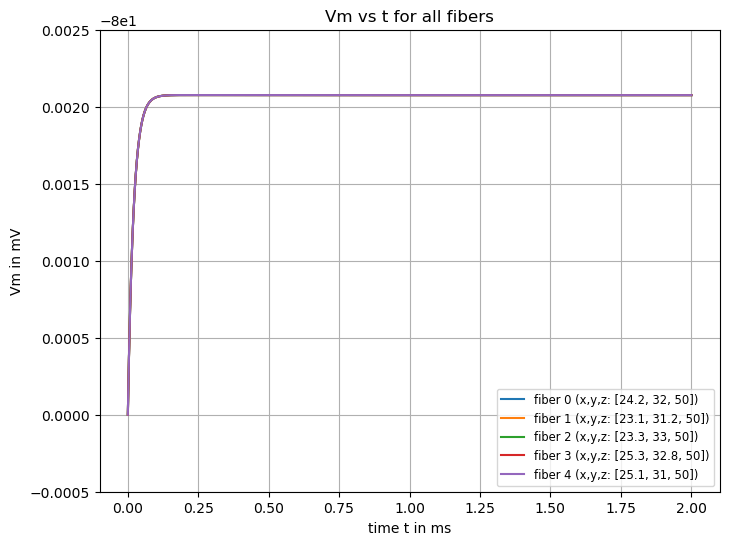

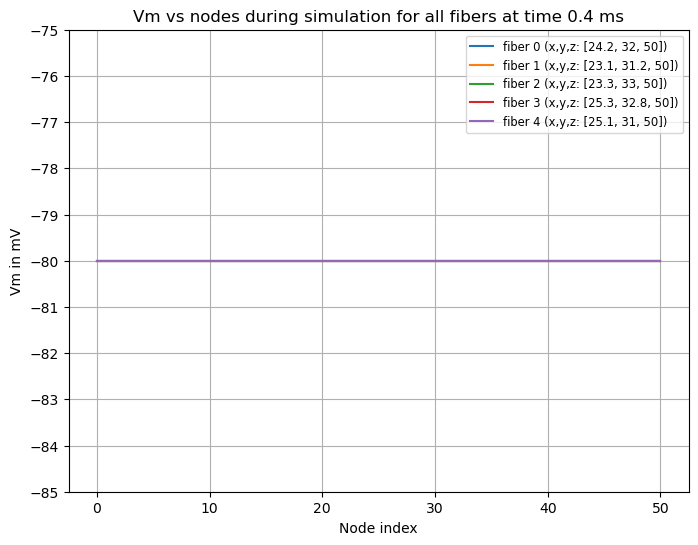

In [58]:
#Plot Vm vs t for central nodes of all fibers for pulsewidths[5]
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    plt.plot(t,Vm_PTN[0][0][5][fiber_index][int(n_fibers_PTN/2)],label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for all fibers')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#Plot Vm spatial variation at mid point of simulation
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    time = stim_delay + pulsewidth/2
    #get Vm at time for all nodes
    Vm_time = np.zeros(n_nodes)
    nodes = np.arange(0,n_nodes)
    for node_index in range(n_nodes):
        Vm_time[node_index] = Vm_PTN[0][0][5][fiber_index][node_index][int(time/dt)]
    plt.plot(nodes,Vm_time,label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('Node index')
plt.title(f'Vm vs nodes during simulation for all fibers at time {time} ms')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

In [9]:
a = [[] for _ in range(len(potentials))]
for i in range(len(potentials)):
    a1 = [[] for _ in range(len(pulsewidths))]
    for j in range(len(pulsewidths)):
        a1[j] = j
    a2 = [[] for _ in range(len(amplitudes))]
    for j in range(len(amplitudes)):
        a2[j] = j
    a[i] = [a1,a2]
    
print(a[1][0][1])

1


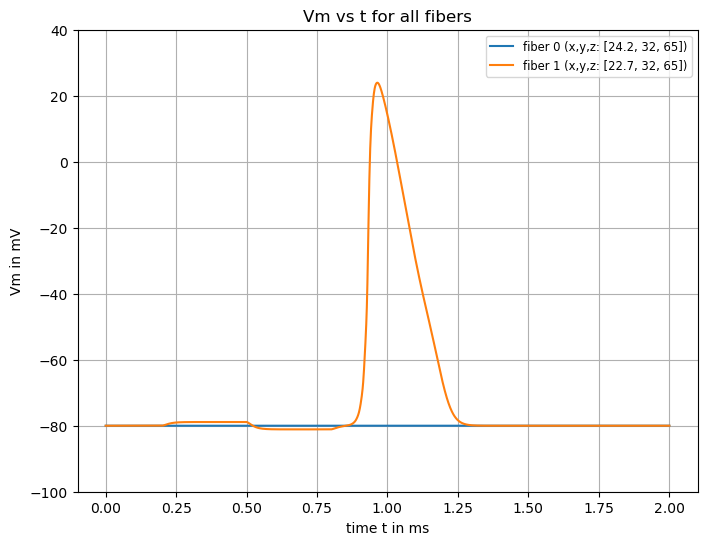

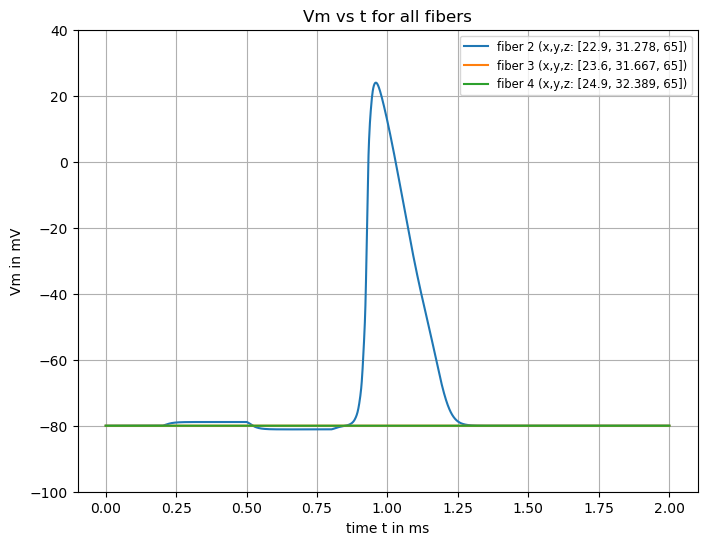

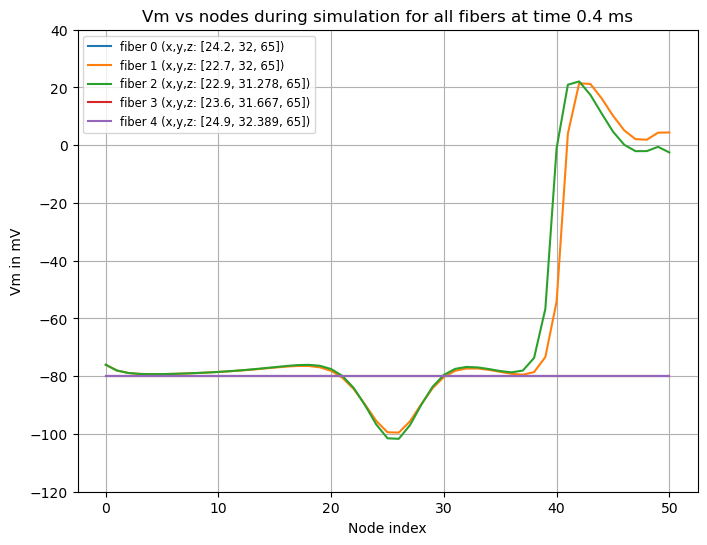

NEURON: point process not located in a section
 near line 0
 ^


TypeError: No value

In [47]:
#Plot Vm vs t for central nodes of all fibers
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,2):
    plt.plot(t,Vm1_PTN[5][fiber_index][int(n_fibers_PTN/2)],label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for all fibers')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(2,5):
    plt.plot(t,Vm1_PTN[5][fiber_index][int(n_fibers_PTN/2)],label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for all fibers')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#Plot Vm spatial variation at mid point of simulation
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers_PTN):
    time = stim_delay + pulsewidth/2
    #get Vm at time for all nodes
    Vm_time = np.zeros(n_nodes)
    nodes = np.arange(0,n_nodes)
    for node_index in range(n_nodes):
        Vm_time[node_index] = Vm1_PTN[5][fiber_index][node_index][int(time/dt)]
    plt.plot(nodes,Vm_time,label=f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fibers_xyz_PTN[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('Node index')
plt.title(f'Vm vs nodes during simulation for all fibers at time {time} ms')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#determine action potential initiation site
t_initiation = 2 
for fiber_index,AP_fiber in enumerate(AP_counts1_PTN[5]):
    for node_index,AP_count in enumerate(AP_fiber):
        if AP_count.time<t_initiation and AP_count.time>0:
            t_initiation = AP_count.time
            fiber_node_AP = [fiber_index,node_index]
        
print('                       AP initiation site : Fiber', fiber_node_AP[0],'Node',fiber_node_AP[1]) 

In [ ]:
    #Insert extracellular stim1 at dummy1 section
    dummy1 = h.Section(name='dummy1')
    ext_stim1 = h.IClamp(dummy1(0.5))
    ext_stim1.dur = stim_duration   #pulse train
    ext_stim1.delay = stim_delay
    ext_stim1.amp = 0      #0 initially, will update during sine wave generation
    #Insert extracellular stim2 at dummy2 section
    dummy2 = h.Section(name='dummy2')
    ext_stim2 = h.IClamp(dummy2(0.5))
    ext_stim2.dur = stim_duration   #pulse train
    ext_stim2.delay = stim_delay
    ext_stim2.amp = 0     #0 initially, will update during sine wave generation
    
    #Generate sine wave stimulus
    def sine_wave_generate():
        if stim_delay<=h.t and h.t<stim_duration+stim_delay:
            ext_stim1.amp = np.sin(2*np.pi*(h.t-stim_delay)/T)*amplitude
            ext_stim2.amp = -np.sin(2*np.pi*(h.t-stim_delay)/T)*amplitude
        else:
            ext_stim1.amp = 0
            ext_stim2.amp = 0

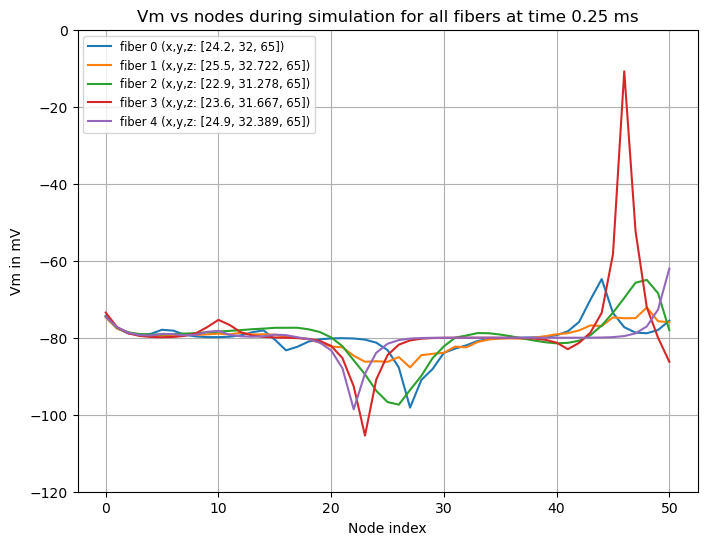

                             AP initiation site : Fiber 3 Node 46


In [16]:
#Plot Vm spatial variation at mid point of simulation
plt.figure(figsize=(8, 6))
legend_labels = []
for fiber_index in range(0,n_fibers):
    time = stim_delay + pulsewidth/2
    #get Vm at time for all nodes
    Vm_time = np.zeros(n_nodes)
    nodes = np.arange(0,n_nodes)
    for node_index in range(n_nodes):
        Vm_time[node_index] = Vm[fiber_index][node_index][int(time/dt)]
    plt.plot(nodes,Vm_time,label=f'fiber {fiber_index} (x,y,z: {fiber_xyz[fiber_index]})')
    legend_labels.append(f'fiber {fiber_index} (x,y,z: {fiber_xyz[fiber_index]})')
plt.ylabel('Vm in mV')
plt.xlabel('Node index')
plt.title(f'Vm vs nodes during simulation for all fibers at time {time} ms')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#determine action potential initiation site
t_initiation = 2 
for fiber_index,AP_fiber in enumerate(AP_counts):
    for node_index,AP_count in enumerate(AP_fiber):
        if AP_count.time<t_initiation and AP_count.time>0:
            t_initiation = AP_count.time
            fiber_node_AP = [fiber_index,node_index]
        
print('                             AP initiation site : Fiber', fiber_node_AP[0],'Node',fiber_node_AP[1]) 

-80.0

In [30]:
#Function to get 1D potentials along z axis for a particular (x,y)
def get_potentials_z(potentials,x,y):
    '''
    potentials: COMSOL 3D potential distribution
    x: target x, in mm
    y: target y, in mm
    '''
    # Define tolerance
    tolerance = 0.05
    # Filter the data based on the target (x, y) value and tolerance
    filtered_data = potentials[(np.abs(potentials[:, 0] - x) <= tolerance) & (np.abs(potentials[:, 1] - y) <= tolerance)]
    # Extract (z, potentials) from the filtered data
    potentials_z = np.column_stack((filtered_data[:, 2], filtered_data[:, 3]))
    
    return potentials_z

x=25.5
y=32.667
potentials_z = get_potentials_z(potentials,x,y)
print("Resulting array of (z, potentials) for (x={}, y={}): ".format(x, y))
print(potentials_z.shape)

Resulting array of (z, potentials) for (x=25.5, y=32.667): 
(807, 2)


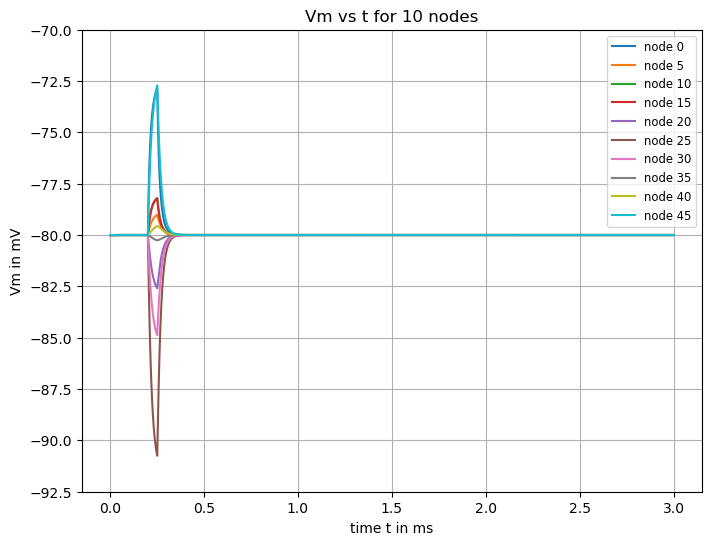

AP initiation site: Node 48


In [39]:
#Simulate 1 fiber using Sweeney model
#Note: Potentials generated for 1mA current, amplitude scaled using 'amplitude' variable, 
#Adjust electrode_xyz and fiber_xyz based on COMSOL

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
#sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 51  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
#electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 3   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms
diameter = 12  #fiber diameter in μm
amplitude = 9   #stimulation amplitude in mA
pulsewidth = 0.05   #stimulation pulsewidth in ms 
fiber_xyz = [24.2,32,65]  #fiber central node [x,y,z] coordinates as per COMSOL, in mm  
electrode_xyz = [18.98,29.1,65]   #electrode reference point current source [x,y,z] coordinates as per COMSOL, in mm

# Load potential distribution, uncomment if not loaded in previous cell
'''
with open('YZ_slice.txt', 'r') as file:
    # Read lines from the file
     lines = file.readlines()
matrix_data = []
for line in lines:
    elements = line.strip().split()
    matrix_data.append([float(elem) for elem in elements])
potentials = np.array(matrix_data)
'''

#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #MRG mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Utility functions==============================================================================================================                

#Function to get 1D potentials along z axis for a particular (x,y)
def get_potentials_z(potentials,x,y):
    '''
    potentials: COMSOL 3D potential distribution
    x: target x, in mm
    y: target y, in mm
    '''
    # Define tolerance
    tolerance = 0.01
    # Filter the data based on the target (x, y) value and tolerance
    filtered_data = potentials[(np.abs(potentials[:, 0] - x) <= tolerance) & (np.abs(potentials[:, 1] - y) <= tolerance)]
    # Extract (z, potentials) from the filtered data
    potentials_z = np.column_stack((filtered_data[:, 2], filtered_data[:, 3]))
    
    return potentials_z    

#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(diameter,fiber_xyz,potentials,pulsewidth,Vm_threshold,tstop):
    '''
    diameter: fiber diameter, in um
    fiber_xyz: fiber central node [[x1,y1,z1],[x2,y2,z2],..] coordinates as per COMSOL in mm
    potentials: potential distribution matrix [distances, potentials]
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    Vm_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert extracellular stim at dummy section
    dummy = h.Section(name='dummy')
    ext_stim = h.IClamp(dummy(0.5))
    ext_stim.dur = pulsewidth  
    ext_stim.delay = stim_delay
    ext_stim.amp = amplitude
    
    #Create fiber model
    global fiber
    fiber = myelin_fiber(diameter)
    
    #Calculate and update extracellular potential at different nodes
    phi_e = []    #Array to store phi_e
    #Get potentials along z-axis for fiber (x,y) coordinates
    potentials_z = get_potentials_z(potentials,fiber_xyz[0],fiber_xyz[1])
    #Function to 1D interpolate potential along z-axis
    interpolate_potentials = interp1d(potentials_z[:,0], potentials_z[:,1])
    for node_index,node in enumerate(fiber.nodes):
        #Get z coord of the node
        node_z = fiber_xyz[2] + 1e-3*(100*D+L)*(int(total_nodes/2)-node_index)      
        #Interpolate extracellular potential at this node (for 1mA stimulation)
        phi_e.append(1e+3*interpolate_potentials(node_z))
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node
    AP_counts = []
    for i,sec in enumerate(fiber.nodes):
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = Vm_threshold
        AP_count.record()
        AP_counts.append(AP_count)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for node_index,node in enumerate(fiber.nodes):
            node(0.5).extracellular.e = phi_e[node_index]*ext_stim.i
        h.fadvance()
        
    return Vm,t,AP_counts

# Run simulation and plot======================================================================================================================

Vm,t,AP_counts = run_simulation(diameter,fiber_xyz,potentials,pulsewidth,Vm_threshold,tstop)

#Plot Vm vs t for 10 nodes
plt.figure(figsize=(8, 6))
legend_labels = []
for node_index in range(0,10):
    plt.plot(t,Vm[node_index*5],label=f'node {node_index*5}')
    legend_labels.append(f'node {node_index*5}')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for 10 nodes')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.yticks(plt.gca().get_yticks())
plt.show()

#determine action potential initiation site
t_initiation = 2 
for node_index,AP_count in enumerate(AP_counts):
    if AP_count.time<t_initiation and AP_count.time>0:
        t_initiation = AP_count.time
        node_AP = node_index
        
print("AP initiation site: Node",node_AP)
    


In [15]:
from scipy.interpolate import interp1d


interpolate_potentials = interp1d(potentials[:,0], potentials[:,1])
r1w = 50

print("Interpolated value at r1w:", interpolate_potentials(r1w))

Interpolated value at r1w: -0.004183549032748039


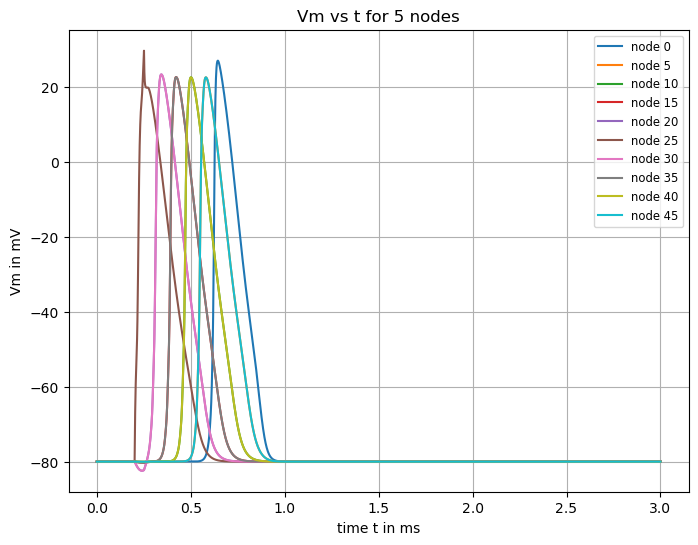

In [25]:
from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 51  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 3   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms
diameter = 12
amplitude = -3e+5
pulsewidth = 0.05


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #MRG mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))
                
 #Insert extracellular stim at dummy section
dummy = h.Section(name='dummy')
ext_stim = h.IClamp(dummy(0.5))
ext_stim.dur = pulsewidth  
ext_stim.delay = stim_delay
ext_stim.amp = amplitude
    
#Create fiber model
global fiber
fiber = myelin_fiber(diameter)
    
#Calculate and update extracellular potential at different nodes
phi_e = []
for node_index,node in enumerate(fiber.nodes):
    #Calculate Ve at each node considering ext_stim applied at 'electrode_distance' distance from central node
    r = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(int(total_nodes/2)-node_index))**2)  #distance of ext_stim from this node in cm
    phi_e.append(1e-6/(4*np.pi*sigma_e*r)) #Calculate phi_e at this node
        
#Reset simulation time
h.t = 0
    
#Record Vm and t
Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
t = h.Vector().record(h._ref_t)

#Initialize simulation
h.finitialize(Vo)
    
#Run simulation until 'tstop'
while h.t<tstop:
    #Update extracellular voltage
    for node_index,node in enumerate(fiber.nodes):
        node(0.5).extracellular.e = phi_e[node_index]*ext_stim.i
    h.fadvance()

#Plot Vm vs t for 10 nodes
plt.figure(figsize=(8, 6))
legend_labels = []
for node_index in range(0,10):
    plt.plot(t,Vm[node_index*5],label=f'node {node_index*5}')
    legend_labels.append(f'node {node_index*5}')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for 5 nodes')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.show()


In [2]:
#Code for Problem 1.1)

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 21  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 1   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('axnode')  #MRG mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(diameter,electrode_distance,amplitude,pulsewidth,voltage_threshold,tstop):
    '''
    diameter: fiber diameter, in um
    electrode_distance: electrode distance from central node, in um
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    voltage_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert extracellular stim at dummy section
    dummy = h.Section(name='dummy')
    ext_stim = h.IClamp(dummy(0.5))
    ext_stim.dur = pulsewidth  
    ext_stim.delay = stim_delay
    ext_stim.amp = amplitude
    
    #Create fiber model
    global fiber
    fiber = myelin_fiber(diameter)
    
    #Calculate and update extracellular potential at different nodes
    phi_e = []
    for node_index,node in enumerate(fiber.nodes):
        #Calculate Ve at each node considering ext_stim applied at 'electrode_distance' distance from central node
        r = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(int(total_nodes/2)-node_index))**2)  #distance of ext_stim from this node in cm
        phi_e.append(1e-6/(4*np.pi*sigma_e*r)) #Calculate phi_e at this node
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node
    AP_counts = []
    for i,sec in enumerate(fiber.nodes):
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = voltage_threshold
        AP_count.record()
        AP_counts.append(AP_count)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for node_index,node in enumerate(fiber.nodes):
            node(0.5).extracellular.e = phi_e[node_index]*ext_stim.i
        h.fadvance()
        
    return Vm,t,AP_counts

#Function to check for propogating AP
def AP_propogation(AP_counts):
    #Check for AP count at 2 distal nodes and make sure they happened at different times (hence propogating)
    if AP_counts[1].n>0 and AP_counts[4].n>0 and AP_counts[1].time!=AP_counts[4].time:
        return 1
    else:
        return 0

#Set parameters and run simulations=============================================================================================

#Generate different stimulation pulse durations in ms
stim_durations = np.array([10,20,50,100,200,500,1000,2000,5000,10000])*0.001

#Create array to store threshold stimulation currents
I_thresholds = np.array([])

#Determining threshold stimulation current for various stim durations 
for stim_duration in stim_durations:  
    
    #If stim_duration is 1ms or above, increase simulation time
    if stim_duration>0.5:
        tstop = 11
        
    #Binary search initialize
    I_min = 0   #initial lower limit for ext_stim amplitude in nA
    I_max = 5e+7  #initial upper limit for ext_stim amplitude in nA
    tolerance = 1   #% tolerance for threshold stimulation precision
    
    #Check if upper limit amplitude produces AP, else raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,-I_max,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==0:
        raise Exception(f'Increase amplitude upper limit. \n\t{I_max} nA did not fire an AP!')
    #Check if lower limit amplitude produces AP, if yes raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,-I_min,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==1:
        raise Exception(f'Reduce amplitude lower limit. \n\t{I_min} nA fired an AP!')
        
    #Binary search loop
    while (I_max-I_min)/I_max >= tolerance/100:
        Vm,t,AP_counts = run_simulation(D,electrode_distance,-(I_min+I_max)/2,stim_duration,Vm_threshold,tstop)     
        AP = AP_propogation(AP_counts)
        #Update I_max or I_min
        if AP==0:
            I_min = (I_min+I_max)/2
        elif AP==1:
            I_max = (I_min+I_max)/2 
   
    #Store threshold current
    I_thresholds = np.append(I_thresholds,(I_min+I_max)/2)

#Visualize results==============================================================================================================    

#Plot threshold stimulation current vs stimulation duration   
plt.plot(stim_durations, I_thresholds*1e-3)
plt.ylabel('Threshold stimulation current in μA')
plt.xlabel('pulse duration in ms')
plt.xscale('log')
plt.title('Strength-duration curve (Cathodic)')
plt.show()

#Store these threshold stimulation currents and stimulation durations for later use
strength_duration_problem1 = [I_thresholds,stim_durations]

Exception: Increase amplitude upper limit. 
	50000000.0 nA did not fire an AP!

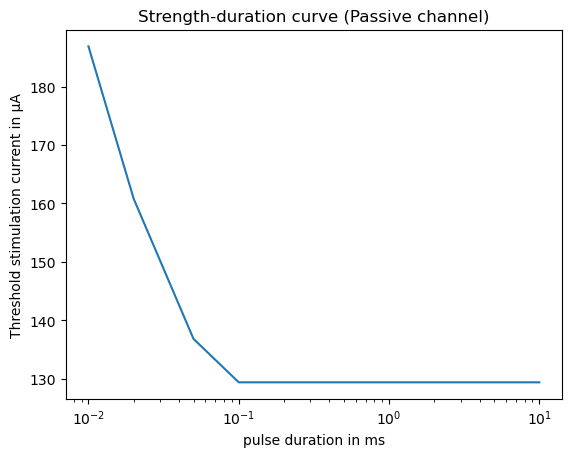

In [61]:
#Code for Problem 1.2)

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
gl = 0.128  # leak channel conductance per unit area in S/cm^2
el = -80.01 # Nernst potential for leakage channel in mV 
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 21  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 20  # Threshold change in transmembrane voltage in mV
h.tstop = 1   #simulation duration in ms 
h.dt = 0.001   #simulation time step in ms


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self):
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*D  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*D)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('pas')      #passive leak channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.pas.g = gl      #leak channel conductance per unit area
                seg.pas.e = el      #Nernst potential for leakage channel
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Define extracellular stimulation, functions to update Ve at each node, reset and record Vm===================================== 

#Insert extracellular stim at dummy section
dummy = h.Section(name='dummy')
ext_stim = h.IClamp(dummy(0.5))
ext_stim.dur = 0  #initially 0, will be updated later using set_stim_amp_dur()
ext_stim.delay = stim_delay
ext_stim.amp = 0  #initially 0, will be updated during binary search using set_stim_amp_dur()

#Function to set external stimulation amplitude and duration
def set_stim_amp_dur(amp,dur):
    # 'amp': input external stimulation amplitude in nA
    # 'dur': input external stimulation duration in ms
    ext_stim.amp = -amp
    ext_stim.dur = dur

#Function to calculate and update extracellular potential at different nodes
def update_Ve(): 
    for node_index,node in enumerate(fiber.nodes):
        #Calculate Ve at each node considering ext_stim applied at 'electrode_distance' distance from central node(25)
        r = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(int(total_nodes/2)-node_index))**2)  #distance of ext_stim from this node in cm
        node(0.5).extracellular.e = 1e-6*ext_stim.i/(4*np.pi*sigma_e*r)   ##calculate and update Ve (mV) at this node
        
#Function to update Ve along with Neuron simulation:
def custom_advance():
    update_Ve()
    h.fadvance()
    
#Function to reset and record Vm        
def reset_recording():  
    global Vm, t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)

# Changing the default run procedure to include custom_advance() 
h(r"""
proc advance() {
    nrnpython("custom_advance()")
}""")

#Create fiber model and determine threshold stim current for various stimulation durations==============================================================        

#Generate different stimulation pulse durations in ms
stim_durations = np.array([10,20,50,100,200,500,1000,2000,5000,10000])*0.001
#Create array to store threshold stimulation currents
I_thresholds = np.array([])

#Determining threshold stimulation current for various stim durations
for stim_duration in stim_durations:  
    
    #Increase stimulation time if pulse duration is large
    if stim_duration>0.5:
        h.tstop = 11
        
    #Stimulate with an amplitude amp_1
    amp_1 = 1e+6    # units: nA
    reset_recording()
    set_stim_amp_dur(amp_1,stim_duration)
    update_Ve()
    h.finitialize(Vo)
    h.continuerun(h.tstop)
    
    #Determine threshold current
    I_threshold = np.abs(amp_1)*Vm_threshold/(np.max(Vm)-Vo)   # in nA
    
    #Store threshold current
    I_thresholds = np.append(I_thresholds,I_threshold)

#Visualize results==============================================================================================================    
    
#Plot threshold stimulation current vs stimulation duration   
plt.plot(stim_durations, I_thresholds*1e-3)
plt.ylabel('Threshold stimulation current in μA')
plt.xlabel('pulse duration in ms')
plt.xscale('log')  #using log scale for pulse duration for better curve visualization
plt.title('Strength-duration curve (Passive channel)')
plt.show()

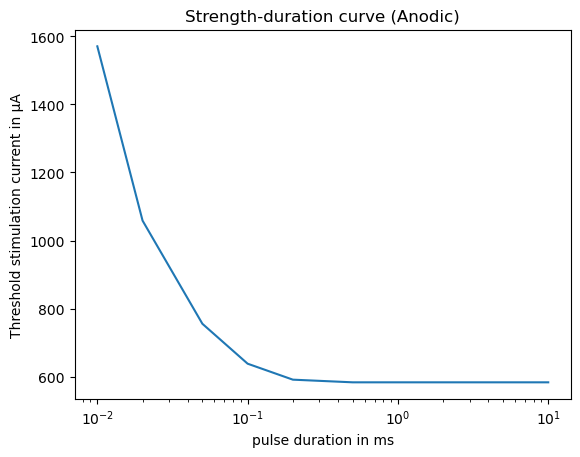

anodic stimulation current: 597.71484375 μA
cathodic stimulation current: -108.0029296875 μA
Anodic AP initiation site (relative to central node): Node 3
Cathodic AP initiation site (relative to central node): Node 0


In [62]:
#Code for problem 1.3

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 21  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 1   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #sweeney mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(diameter,electrode_distance,amplitude,pulsewidth,voltage_threshold,tstop):
    '''
    diameter: fiber diameter, in um
    electrode_distance: electrode distance from central node, in um
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    voltage_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert extracellular stim at dummy section
    dummy = h.Section(name='dummy')
    ext_stim = h.IClamp(dummy(0.5))
    ext_stim.dur = pulsewidth  
    ext_stim.delay = stim_delay
    ext_stim.amp = amplitude
    
    #Create fiber model
    global fiber
    fiber = myelin_fiber(diameter)
    
    #Calculate and update extracellular potential at different nodes
    phi_e = []
    for node_index,node in enumerate(fiber.nodes):
        #Calculate phi_e at each node considering ext_stim applied at 'electrode_distance' distance from central node
        r = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(int(total_nodes/2)-node_index))**2)  #distance of ext_stim from this node in cm
        phi_e.append(1e-6/(4*np.pi*sigma_e*r)) #Calculate phi_e at this node
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node
    AP_counts = []
    for i,sec in enumerate(fiber.nodes):
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = voltage_threshold
        AP_count.record()
        AP_counts.append(AP_count)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for node_index,node in enumerate(fiber.nodes):
            node(0.5).extracellular.e = phi_e[node_index]*ext_stim.i
        h.fadvance()
        
    return Vm,t,AP_counts

#Function to check for propogating AP
def AP_propogation(AP_counts):
    #Check for AP count at 2 distal nodes and make sure they happened at different times (hence propogating)
    if AP_counts[1].n>0 and AP_counts[4].n>0 and AP_counts[1].time!=AP_counts[4].time:
        return 1
    else:
        return 0

#Set parameters and run simulations=============================================================================================

#Generate different stimulation pulse durations in ms
stim_durations = np.array([10,20,50,100,200,500,1000,2000,5000,10000])*0.001

#Create array to store threshold stimulation currents
I_thresholds = np.array([])

#Determining threshold stimulation current for various stim durations 
for stim_duration in stim_durations:  
    
    #If stim_duration is 1ms or above, increase simulation time
    if stim_duration>0.5:
        tstop = 11
        
    #Binary search initialize
    I_min = 0   #initial lower limit for ext_stim amplitude in nA
    I_max = 2e+6  #initial upper limit for ext_stim amplitude in nA
    tolerance = 1   #% tolerance for threshold stimulation precision
    
    #Check if upper limit amplitude produces AP, else raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,I_max,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==0:
        raise Exception(f'Increase amplitude upper limit. \n\t{I_max} nA did not fire an AP!')
   #Check if lower limit amplitude produces AP, if yes raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,I_min,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==1:
        raise Exception(f'Reduce amplitude lower limit. \n\t{I_min} nA fired an AP!')
        
    #Binary search loop
    while (I_max-I_min)/I_max >= tolerance/100:
        Vm,t,AP_counts = run_simulation(D,electrode_distance,(I_min+I_max)/2,stim_duration,Vm_threshold,tstop)     
        AP = AP_propogation(AP_counts)
        #Update I_max or I_min
        if AP==0:
            I_min = (I_min+I_max)/2
        elif AP==1:
            I_max = (I_min+I_max)/2 
   
    #Store threshold current
    I_thresholds = np.append(I_thresholds,(I_min+I_max)/2)

#Visualize results==============================================================================================================    

#Plot threshold stimulation current vs stimulation duration   
plt.plot(stim_durations, I_thresholds*1e-3)
plt.ylabel('Threshold stimulation current in μA')
plt.xlabel('pulse duration in ms')
plt.xscale('log')
plt.title('Strength-duration curve (Anodic)')
plt.show()

#Determine and compare the sites of action potential initiation=================================================================

stim_duration = 200    # stimulation pulse width, in ms
I_stim_anodic = I_thresholds[4]*1.01 #taking stimulation current slightly greater than what we determined for 200us pulsewidth
I_stim_cathodic = -strength_duration_problem1[0][4]*1.01    #from problem 1

print("anodic stimulation current:",I_stim_anodic*1e-3,"μA")
print("cathodic stimulation current:",I_stim_cathodic*1e-3,"μA")

#Run simulation for anodic
Vm,t,AP_counts = run_simulation(D,electrode_distance,I_stim_anodic,stim_duration,Vm_threshold,tstop=1)
#determine action potential initiation site
t_initiation = 10 
for node_index,AP_count in enumerate(AP_counts):
    if AP_count.time<t_initiation and AP_count.time>0:
        t_initiation = AP_count.time
        node_anode = node_index

#Run simulation for cathodic
Vm,t,AP_counts = run_simulation(D,electrode_distance,I_stim_cathodic,stim_duration,Vm_threshold,tstop=1)
#determine action potential initiation site
t_initiation = 10 
for node_index,AP_count in enumerate(AP_counts):
    if AP_count.time<t_initiation and AP_count.time>0:
        t_initiation = AP_count.time
        node_cathode = node_index

print("Anodic AP initiation site (relative to central node): Node",np.abs(10-node_anode))
print("Cathodic AP initiation site (relative to central node): Node",np.abs(10-node_cathode))

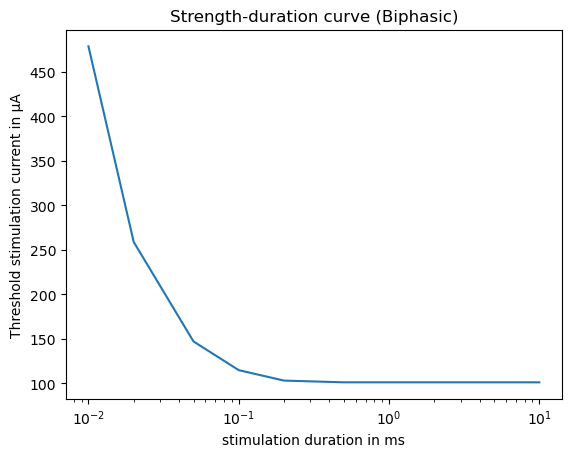

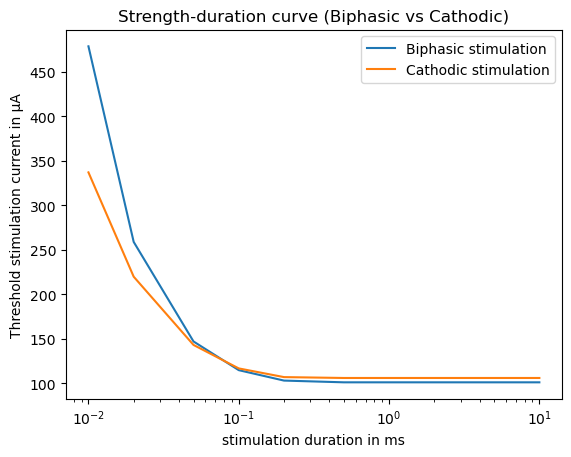

In [63]:
#Code for Problem 1.4)

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
total_nodes = 21  # Number of nodes of Ranvier
L = 1.5  # Length of nodes of Ranvier (μm)
D = 12 # fiber diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
electrode_distance = 1000  # Distance of electrode from central node in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 2   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = 0.6*self.diam  #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #sweeney mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(diameter,electrode_distance,amplitude,pulsewidth,voltage_threshold,tstop):
    '''
    diameter: fiber diameter, in um
    electrode_distance: electrode distance from central node, in um
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    voltage_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert biphasic extracellular stim first phase (Anodic)
    dummy1 = h.Section(name='dummy1')
    ext_stim1 = h.IClamp(dummy1(0.5))
    ext_stim1.dur = pulsewidth  
    ext_stim1.delay = stim_delay
    ext_stim1.amp = amplitude
    #Insert biphasic extracellular stim second phase (Cathodic)
    dummy2 = h.Section(name='dummy2')
    ext_stim2 = h.IClamp(dummy2(0.5))
    ext_stim2.dur = pulsewidth  
    ext_stim2.delay = stim_delay+pulsewidth
    ext_stim2.amp = -amplitude
    
    #Create fiber model
    global fiber
    fiber = myelin_fiber(diameter)
    
    #Calculate and update extracellular potential at different nodes
    phi_e = []
    for node_index,node in enumerate(fiber.nodes):
        #Calculate Ve at each node considering ext_stim applied at 'electrode_distance' distance from central node
        r = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(int(total_nodes/2)-node_index))**2)  #distance of ext_stim from this node in cm
        phi_e.append(1e-6/(4*np.pi*sigma_e*r)) #Calculate phi_e at this node
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node
    AP_counts = []
    for i,sec in enumerate(fiber.nodes):
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = voltage_threshold
        AP_count.record()
        AP_counts.append(AP_count)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #Update extracellular voltage
        for node_index,node in enumerate(fiber.nodes):
            node(0.5).extracellular.e = phi_e[node_index]*(ext_stim1.i+ext_stim2.i)
        h.fadvance()
        
    return Vm,t,AP_counts

#Function to check for propogating AP
def AP_propogation(AP_counts):
    #Check for AP count at 2 distal nodes and make sure they happened at different times (hence propogating)
    if AP_counts[1].n>0 and AP_counts[4].n>0 and AP_counts[1].time!=AP_counts[4].time:
        return 1
    else:
        return 0

#Set parameters and run simulations=============================================================================================

#Generate different stimulation pulse durations in ms
stim_durations = np.array([10,20,50,100,200,500,1000,2000,5000,10000])*0.001

#Create array to store threshold stimulation currents
I_thresholds = np.array([])

#Determining threshold stimulation current for various stim durations 
for stim_duration in stim_durations:  
    
    #If stim_duration is 0.5ms or above, increase simulation time
    if stim_duration>0.5:
        tstop = 21
        
    #Binary search initialize
    I_min = 0   #initial lower limit for ext_stim amplitude in nA
    I_max = 2e+6  #initial upper limit for ext_stim amplitude in nA
    tolerance = 1   #% tolerance for threshold stimulation precision
    
    #Check if upper limit amplitude produces AP, else raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,I_max,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==0:
        raise Exception(f'Increase amplitude upper limit. \n\t{I_max} nA did not fire an AP!')
    #Check if lower limit amplitude produces AP, if yes raise exception
    Vm,t,AP_counts = run_simulation(D,electrode_distance,I_min,stim_duration,Vm_threshold,tstop) 
    AP = AP_propogation(AP_counts)
    if AP==1:
        raise Exception(f'Reduce amplitude lower limit. \n\t{I_min} nA fired an AP!')
        
    #Binary search loop
    while (I_max-I_min)/I_max >= tolerance/100:
        Vm,t,AP_counts = run_simulation(D,electrode_distance,(I_min+I_max)/2,stim_duration,Vm_threshold,tstop)     
        AP = AP_propogation(AP_counts)
        #Update I_max or I_min
        if AP==0:
            I_min = (I_min+I_max)/2
        elif AP==1:
            I_max = (I_min+I_max)/2 

    I_thresholds = np.append(I_thresholds,(I_min+I_max)/2)

#Visualize results==============================================================================================================    

#Plot threshold stimulation current vs stimulation duration
plt.plot(stim_durations, I_thresholds*1e-3, label = 'Biphasic stimulation')
plt.ylabel('Threshold stimulation current in μA')
plt.xlabel('stimulation duration in ms')
plt.xscale('log')
plt.title('Strength-duration curve (Biphasic)')
plt.show()

#Plot and compare biphasic and monophasic stimulation 
plt.plot(stim_durations, I_thresholds*1e-3, label = 'Biphasic stimulation')
plt.plot(strength_duration_problem1[1], strength_duration_problem1[0]*1e-3, label = 'Cathodic stimulation')
plt.ylabel('Threshold stimulation current in μA')
plt.xlabel('stimulation duration in ms')
plt.xscale('log')
plt.title('Strength-duration curve (Biphasic vs Cathodic)')
plt.legend()
plt.show()


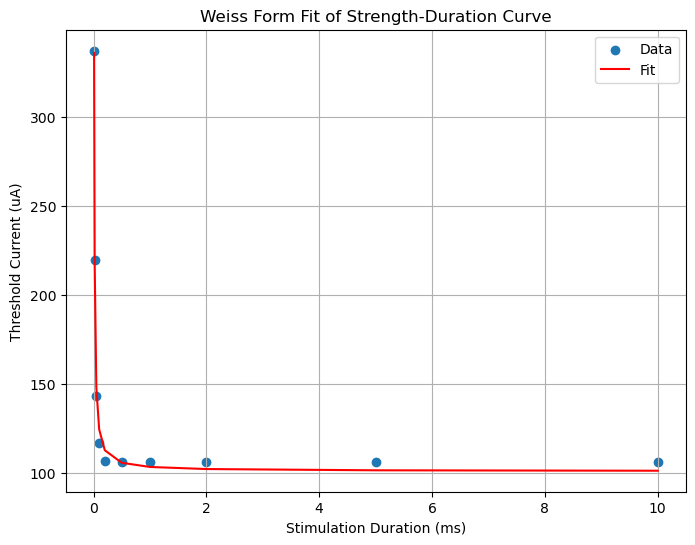

Rheobase (Irh): 101.0166376394305 uA
Chronaxie (Tch): 0.0232256705997025 ms


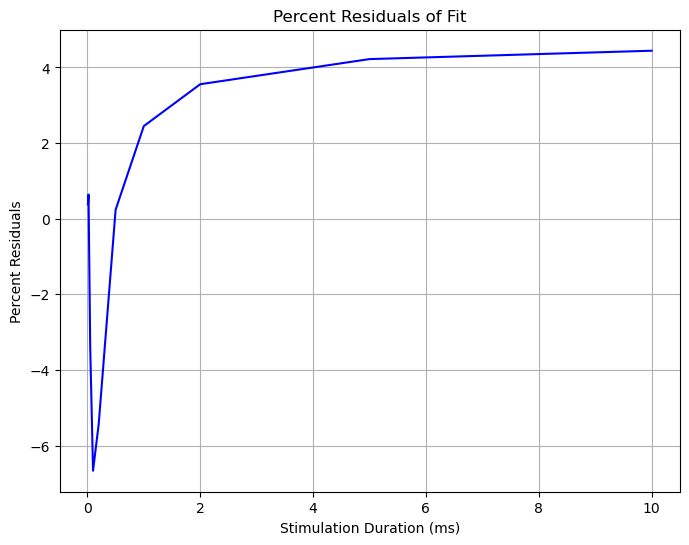

In [27]:
#Code for Problem 1.5)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Taking I_thresholds and stim_durations from Problem 1.1
I_thresholds = strength_duration_problem1[0]
stim_durations = strength_duration_problem1[1]

# Define the Weiss form of the strength-duration curve
def weiss_curve(t, Irh, Tch):
    return Irh * (1 + Tch / t)

# Initial guess for parameters
initial_guess = [1.0, 1.0]

# Fit the curve
params, covariance = curve_fit(weiss_curve, stim_durations, I_thresholds, p0=initial_guess)

# Extracting the fitted parameters
Irh_fit, Tch_fit = params

# Calculate the fitted curve
fit_curve = weiss_curve(stim_durations, Irh_fit, Tch_fit)

# Plot the overlay of the fit on the data
plt.figure(figsize=(8, 6))
plt.scatter(stim_durations, I_thresholds*1e-3, label='Data')
plt.plot(stim_durations, fit_curve*1e-3, color='red', label='Fit')
plt.xlabel('Stimulation Duration (ms)')
plt.ylabel('Threshold Current (uA)')
plt.title('Weiss Form Fit of Strength-Duration Curve')
plt.legend()
plt.grid(True)
plt.show()

# Print rheobase and chronaxie results
print("Rheobase (Irh):", Irh_fit*1e-3,"uA")
print("Chronaxie (Tch):", Tch_fit,"ms")

# Calculate and plot percent residuals
percent_residuals = 100 * (I_thresholds - fit_curve) / I_thresholds

plt.figure(figsize=(8, 6))
plt.plot(stim_durations, percent_residuals, color='blue')
plt.xlabel('Stimulation Duration (ms)')
plt.ylabel('Percent Residuals')
plt.title('Percent Residuals of Fit')
plt.grid(True)
plt.show()

Determined threshold stimulation current: 223.6328125 mA


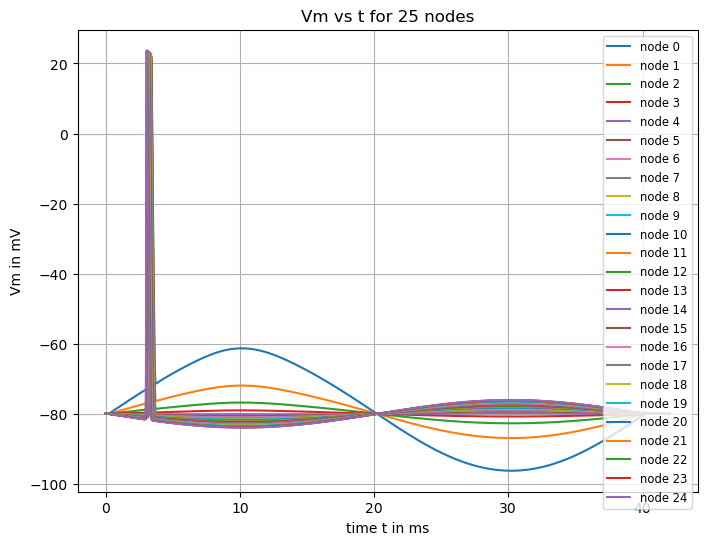

In [55]:
#Code for Problem 2.1)

from neuron import h, gui
from neuron.units import mV,ms
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Define static parameters=============================================================================================================

#Note: considering both electrode sites are separated by 5cm and placed parallel to the nerve fiber at a distance of 3cm. 
#Each site can send upto 60mA, when one is anodic other would be cathodic. First electrode placed above central node of fiber,
#considering only a 51 node section of the nerve fiber

rho_a = 54.7  # Axoplasmic resistivity (Ω-cm)
cm = 2.5  # Specific membrane capacitance (μF/cm^2)
sigma_e = 1/500  #extracellular conductivity (1/Ω-cm) 
L = 1.5  # Length of nodes of Ranvier (μm)
total_nodes = 51  # Number of nodes of Ranvier
D = 8.5 # fiber diameter in μm
d = 5.1 # axon diameter in μm
stim_delay = 0.2  # Stimulation delay in ms
T = 40   #time period of sine wave stimulus (25Hz), in ms 
electrode_distance = 30000  # Distance of electrode sites from central node in μm
central_node = 25     #node above which first electrode is placed
electrode_separation = 50000 #Separation between two electrode sites in μm
Vo = -80  # Resting transmembrane voltage in mV 
Vm_threshold = 0  # Threshold transmembrane voltage in mV, considering an AP peak over Vm=0mV based on research paper
tstop = 42   #simulation duration in ms  
h.dt = 0.001   #simulation time step in ms


#Define fiber model============================================================================================================

class myelin_fiber():
    def __init__(self,diam):
        self.diam = diam    #fiber diameter in μm
        self.setup_model()
        
    def setup_model(self):
        self.nodes = []         #node list
        for node_index in range(0,total_nodes):
            self.nodes.append(h.Section(name = 'Node [%d]'%(node_index+1))) 
            self.nodes[node_index].nseg = 1
            self.nodes[node_index].diam = d       #node diameter in μm
            self.nodes[node_index].L = L          #node length in μm
            self.nodes[node_index].Ra = rho_a*(L+100*self.diam)/L    #axial resistivity accomodating internodal space
            self.nodes[node_index].cm = cm           #specific membrane capacitance
            self.nodes[node_index].insert('sweeney')  #sweeney mod file Na channel
            self.nodes[node_index].insert('extracellular')
            for seg in self.nodes[node_index]:
                seg.extracellular.e = 0      #extracellular stimulation 0 until ext_stim_obj added 
                
            if node_index>0:
                self.nodes[node_index].connect(self.nodes[node_index-1](1))

#Define function to run simulation with stimulation parameters==================================================================

def run_simulation(diameter,electrode_distance,amplitude,stim_duration,voltage_threshold,tstop):
    '''
    diameter: fiber diameter, in um
    electrode_distance: electrode distance from central node, in um
    amplitude: stimulation amplitude, in nA
    pulsewidth: stimulation pulsewidth, in ms
    voltage_threshold: threshold transmembrane voltage for AP, in mV
    tstop: simulation time, in ms
    '''
    
    #Insert extracellular stim1 at dummy1 section
    dummy1 = h.Section(name='dummy1')
    ext_stim1 = h.IClamp(dummy1(0.5))
    ext_stim1.dur = stim_duration   #pulse train
    ext_stim1.delay = stim_delay
    ext_stim1.amp = 0      #0 initially, will update during sine wave generation
    #Insert extracellular stim2 at dummy2 section
    dummy2 = h.Section(name='dummy2')
    ext_stim2 = h.IClamp(dummy2(0.5))
    ext_stim2.dur = stim_duration   #pulse train
    ext_stim2.delay = stim_delay
    ext_stim2.amp = 0     #0 initially, will update during sine wave generation
    
    #Generate sine wave stimulus
    def sine_wave_generate():
        if stim_delay<=h.t and h.t<stim_duration+stim_delay:
            ext_stim1.amp = np.sin(2*np.pi*(h.t-stim_delay)/T)*amplitude
            ext_stim2.amp = -np.sin(2*np.pi*(h.t-stim_delay)/T)*amplitude
        else:
            ext_stim1.amp = 0
            ext_stim2.amp = 0
    
    #Create fiber model
    global fiber
    fiber = myelin_fiber(diameter)
    
    #Calculate and update extracellular potential at different nodes
    phi_e1 = []
    phi_e2 = []
    for node_index,node in enumerate(fiber.nodes):
        #Calculate phi_e at each node due to first electrode
        r1 = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(central_node-node_index))**2)  #distance of ext_stim1 from this node in cm
        phi_e1.append(1e-6/(4*np.pi*sigma_e*r1)) #Calculate phi_e at this node
        #Calculate phi_e at each node due to second electrode
        r2 = 1e-4*np.sqrt((electrode_distance)**2+((100*D+L)*(central_node-node_index)+electrode_separation)**2)  #distance of ext_stim2 from this node in cm
        phi_e2.append(1e-6/(4*np.pi*sigma_e*r2)) #Calculate phi_e at this node
        
    #Reset simulation time
    h.t = 0
    
    #Record Vm and t
    Vm = [h.Vector().record(sec(0.5)._ref_v) for sec in fiber.nodes]
    t = h.Vector().record(h._ref_t)
    
    #Detect AP at each node
    AP_counts = []
    for i,sec in enumerate(fiber.nodes):
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = voltage_threshold
        AP_count.record()
        AP_counts.append(AP_count)
    
    #Initialize simulation
    h.finitialize(Vo)
    
    #Run simulation until 'tstop'
    while h.t<tstop:
        #generate sine wave stimulus
        sine_wave_generate()
        #Update extracellular voltage
        for node_index,node in enumerate(fiber.nodes):
            node(0.5).extracellular.e = phi_e1[node_index]*ext_stim1.i + phi_e2[node_index]*ext_stim2.i
        h.fadvance()
        
    return Vm,t,AP_counts

#Function to check for propogating AP
def AP_propogation(AP_counts):
    #Check for AP count at 2 distal nodes and make sure they happened at different times (hence propogating)
    if AP_counts[1].n>0 and AP_counts[4].n>0 and AP_counts[1].time!=AP_counts[4].time:
        return 1
    else:
        return 0

#Set parameters and run binary search=============================================================================================

#Stimulation duration
stim_duration = 40   # single sinusoidal pulse, ms

#Binary search initialize
I_min = 0   #initial lower limit for ext_stim amplitude in nA
I_max = 5e+8  #initial upper limit for ext_stim amplitude in nA
tolerance = 1   #% tolerance for threshold stimulation precision
    
#Check if upper limit amplitude produces AP, else raise exception
Vm,t,AP_counts = run_simulation(D,electrode_distance,I_max,stim_duration,Vm_threshold,tstop) 
AP = AP_propogation(AP_counts)
if AP==0:
    raise Exception(f'Increase amplitude upper limit. \n\t{I_max} nA did not fire an AP!')
#Check if lower limit amplitude produces AP, if yes raise exception
Vm,t,AP_counts = run_simulation(D,electrode_distance,I_min,stim_duration,Vm_threshold,tstop) 
AP = AP_propogation(AP_counts)
if AP==1:
    raise Exception(f'Reduce amplitude lower limit. \n\t{I_min} nA fired an AP!')
        
#Binary search loop
while (I_max-I_min)/I_max >= tolerance/100:
    Vm,t,AP_counts = run_simulation(D,electrode_distance,(I_min+I_max)/2,stim_duration,Vm_threshold,tstop)     
    AP = AP_propogation(AP_counts)
    #Update I_max or I_min
    if AP==0:
        I_min = (I_min+I_max)/2
    elif AP==1:
        I_max = (I_min+I_max)/2 

I_threshold = (I_min+I_max)/2

#Visualize results==============================================================================================================    

print("Determined threshold stimulation current:", I_threshold*1e-6, "mA")

#Plot Vm vs t for 25 nodes
plt.figure(figsize=(8, 6))
legend_labels = []
for node_index in range(0,25):
    plt.plot(t,Vm[node_index],label=f'node {node_index}')
    legend_labels.append(f'node {node_index}')
plt.ylabel('Vm in mV')
plt.xlabel('time t in ms')
plt.title('Vm vs t for 25 nodes')
plt.grid(True)
plt.legend(legend_labels,fontsize='small')
plt.show()